# PyTorch

note: benchmark results of DDP\
date: 230330a\
author: EI

### on JUWELS-BOOSTER

In [1]:
import os, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
%matplotlib inline
sns.set()
pd.options.display.max_columns = None

In [2]:
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
df = pd.read_csv('/Users/einanc/Work/FZJJUWELS/Synthetic/result-csv.dat',header=0)
df.rename(columns=lambda x: x.split('[')[0], inplace=True)

# gpus
df["NGPUs"] = df["Nnodes"]*4

# speedup
df["Speedup - ideal"] = df["Nnodes"].astype(float)
df["Speedup"] = df["Naet"].iloc[0] / df["Naet"]

# efficiency
df["Threadscaled Sim. Time / s"] = df["Naet"] * df["Nnodes"] * df["Nworkers"]
df["Efficiency"] = df["Threadscaled Sim. Time / s"].iloc[0] / df["Threadscaled Sim. Time / s"]
df

,ID,Nnodes,Nworkers,prefetchF,batchSize,Nepochs,learningRate,calcTime,avgEpochT,Naet,memoryGPU,avgTestLoss,avgMeanDiff,NGPUs,Speedup - ideal,Speedup,Threadscaled Sim. Time / s,Efficiency
0,0,1,24,2,1,10,0.0001,407.44,50.93,50.930,33.9,NaN,NaN,4,1.0,1.000000,1222.320,1.000000
1,1,2,24,2,1,10,0.0001,412.86,51.61,25.805,33.9,NaN,NaN,8,2.0,1.973649,1238.640,0.986824
2,2,4,24,2,1,10,0.0001,415.26,51.91,12.977,33.9,NaN,NaN,16,4.0,3.924636,1245.792,0.981159
3,3,8,24,2,1,10,0.0001,417.49,52.19,6.524,33.9,NaN,NaN,32,8.0,7.806560,1252.608,0.975820
4,4,16,24,2,1,10,0.0001,420.99,52.62,3.289,33.9,NaN,NaN,64,16.0,15.484950,1262.976,0.967809
5,5,32,24,2,1,10,0.0001,421.89,52.74,1.648,33.9,NaN,NaN,128,32.0,30.904126,1265.664,0.965754
6,6,64,24,2,1,10,0.0001,424.90,53.11,0.830,33.9,NaN,NaN,256,64.0,61.361446,1274.880,0.958773
7,7,128,24,2,1,10,0.0001,427.74,53.47,0.418,33.9,NaN,NaN,512,128.0,121.842105,1284.096,0.951891
8,8,256,24,2,1,10,0.0001,433.29,54.16,0.212,33.9,NaN,NaN,1024,256.0,240.235849,1302.528,0.938421
9,9,384,24,2,1,10,0.0001,437.20,54.65,0.142,33.9,NaN,NaN,1536,384.0,358.661972,1308.672,0.934016


## Overview

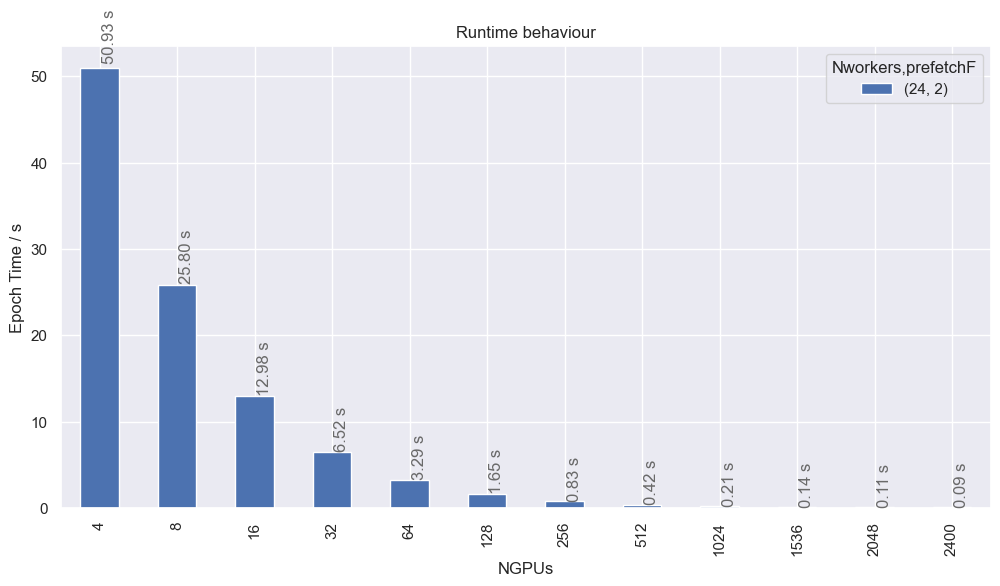

In [4]:
ax = df.pivot_table(index=["NGPUs"], columns=["Nworkers", "prefetchF"], values="Naet").plot(kind="bar", title="Runtime behaviour");
ax.set_ylabel("Epoch Time / s");
ax_abs = ax
for p in ax.patches:
    ax.annotate("{:.2f} s".format(p.get_height()), (p.get_x() + p.get_width()/1.33, p.get_height() * 1.01), \
                color="dimgray", horizontalalignment="center", verticalalignment="bottom", rotation="vertical")
pass

## Scaling Behaviour

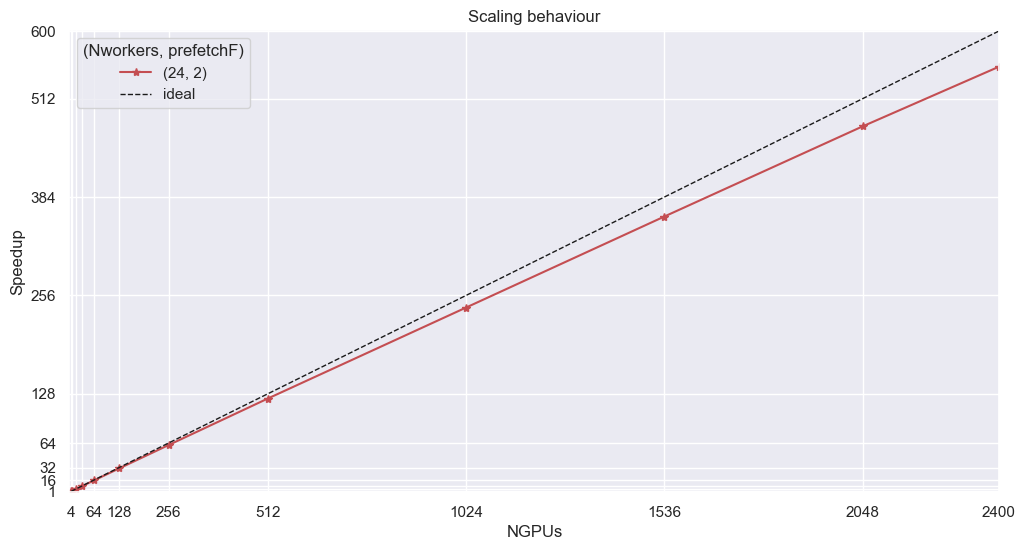

In [5]:
ax = df.pivot_table(index=["NGPUs"], columns=["Nworkers", "prefetchF"], values="Speedup").plot(style="*-", \
    loglog=False, title="Scaling behaviour", color="r", legend=False);
ax.plot(df["NGPUs"].values,df["Speedup - ideal"].values,ls='dashed',lw=1.0,c='k',label="ideal")

ax.legend(ncol=1, title="(Nworkers, prefetchF)")
ax.set_xticks(df["NGPUs"].values)
ax.set_yticks(df["Speedup - ideal"].values)
ax.set_ylabel(r'Speedup')
ax.set_xlim((0,np.amax(df["NGPUs"].values+1)))
ax.set_ylim((0,np.amax(df["Speedup - ideal"].values+1)))

# hide labels if squished
labels_x = [item.get_text() for item in ax.get_xticklabels()]
labels_y = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(df["NGPUs"].values)):
    # hide 2,3,4th labels
    labels_x[i] = '' if 0<i<4 else df["NGPUs"].values[i]
    labels_y[i] = '' if 0<i<4 else int(df["Speedup - ideal"].values[i])
ax.set_xticklabels(labels_x)
ax.set_yticklabels(labels_y)
pass

## Runtime Efficiencies

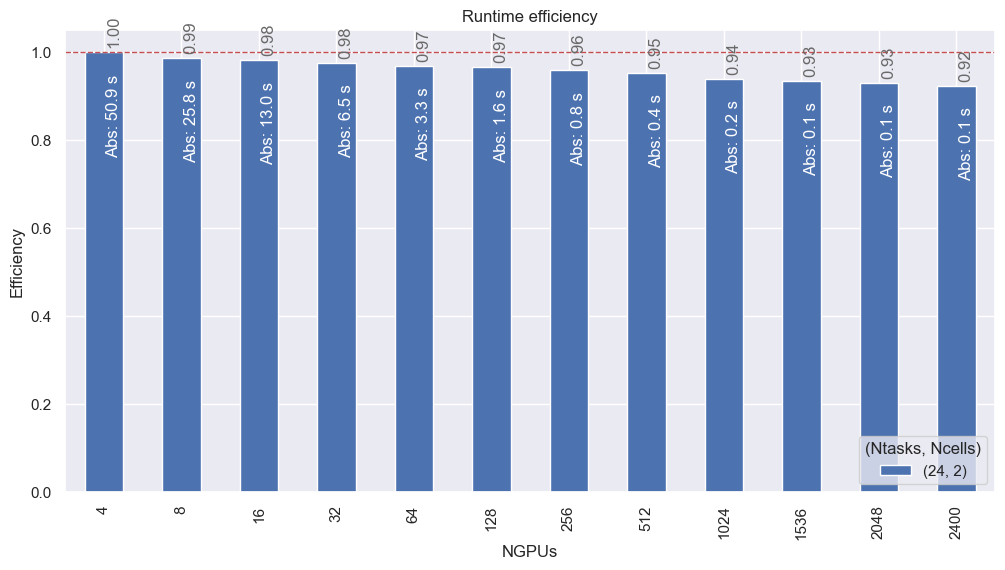

In [6]:
ax = df.pivot_table(index=["NGPUs"], columns=["Nworkers", "prefetchF"], values="Efficiency").plot(kind="bar", \
    legend=False, title="Runtime efficiency")
ax.legend(ncol=1, title="(Ntasks, Ncells)",loc=4)
ax.set_ylabel("Efficiency");
for p, abs in zip(ax.patches, ax_abs.patches):
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() + p.get_width()/1.33, p.get_height() * 1.01), \
        color="dimgray", horizontalalignment="center", verticalalignment="bottom", rotation="vertical")
    ax.annotate("Abs: {:.1f} s".format(abs.get_height()), (p.get_x() + p.get_width()/1.33, p.get_height() * 0.95), \
        color="white", horizontalalignment="center", verticalalignment="top", rotation="vertical")
ax.plot(df["NGPUs"].values-8,df["Speedup - ideal"].values*0+1,ls='dashed',lw=1.0,c='r',label="ideal")
pass

In [7]:
# EOF